In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shibumohapatra/house-price")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/house-price


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
df_original = pd.read_csv('https://github.com/dipdhru/ml_al_ds_learning/raw/refs/heads/main/house_prices.csv.zip')

#Shape & Size of data set
print(f'Original Dataset Shape : {df_original.shape} & Original Dataset size : {df_original.size}')

Original Dataset Shape : (187531, 21) & Original Dataset size : 3938151


In [20]:
#Train Test Split
df_train, df_test = train_test_split(df_original, test_size=0.3, random_state=42)

#Size & Size of Train & Test
print(f'Train Dataset Shape : {df_train.shape} & Train Dataset Shape : {df_train.shape}','\n')
print(f'Test Dataset Shape : {df_test.shape} & Test Dataset Shape : {df_test.shape}','\n','- '*25)

#Look on columns datatypes
print(df_train.dtypes)

Train Dataset Shape : (131271, 21) & Train Dataset Shape : (131271, 21) 

Test Dataset Shape : (56260, 21) & Test Dataset Shape : (56260, 21) 
 - - - - - - - - - - - - - - - - - - - - - - - - - 
Index                  int64
Title                 object
Description           object
Amount(in rupees)     object
Price (in rupees)    float64
location              object
Carpet Area           object
Status                object
Floor                 object
Transaction           object
Furnishing            object
facing                object
overlooking           object
Society               object
Bathroom              object
Balcony               object
Car Parking           object
Ownership             object
Super Area            object
Dimensions           float64
Plot Area            float64
dtype: object


In [21]:
#Total Duplicates
print(f'Total Duplicates in Train Dataset : {df_train.duplicated().sum()}')

#Total Null
print(f'Total Nulls in Train Dataset : {df_train.isna().sum().sum()}','\n','- '*25)

#Statistical Analysis
df_train.describe(include='all').T

Total Duplicates in Train Dataset : 0
Total Nulls in Train Dataset : 751861 
 - - - - - - - - - - - - - - - - - - - - - - - - - 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Index,131271.0,NaN,NaN,NaN,93631.553915,54105.37878,1.0,46853.5,93606.0,140307.5,187530.0
Title,131271,25614,2 BHK Ready to Occupy Flat for sale in Divyasr...,1466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,129111,46356,Multistorey apartment is available for sale. I...,1929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount(in rupees),131271,1484,Call for Price,6791,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price (in rupees),118920.0,NaN,NaN,NaN,7559.136319,26137.889071,0.0,4299.0,6034.0,9462.25,6700000.0
location,131271,81,new-delhi,19323,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Carpet Area,74816,2471,1000 sqft,3646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Status,130845,1,Ready to Move,130845,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Floor,126341,887,2 out of 4,8750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transaction,131212,4,Resale,100775,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#Function to analyse all Explicit & Implicit null values, Unique Values & Total Rows
def analyze_missing_value(df, z_threshold=3):
    summary = {
        "Column Name": df.columns.tolist() + ["Total"],
        "Data Type": [df[col].dtype for col in df.columns] + [": -"],
        "Unique Values": [df[col].nunique() for col in df.columns] + [""],
        "Total Rows": [len(df)] * (len(df.columns) + 1),
        "Explicit Nulls": [df[col].isna().sum() for col in df.columns] + [df.isna().sum().sum()],
        "Implicit Nulls": [
            # Checking for empty, dash, space, zero, or zero equivalent in implicit nulls
            df[col].astype(str).str.strip().isin(["NA","", "-", " ", "0", "0.0"]).sum() + (df[col] == 0).sum()
            for col in df.columns
        ] + [sum(
            df[col].astype(str).str.strip().isin(["NA","", "-", " ", "0", "0.0"]).sum() + (df[col] == 0).sum()
            for col in df.columns
        )]
    }

    # Aggregation
    summary["Total Nulls"] = [
        summary["Explicit Nulls"][i] + summary["Implicit Nulls"][i] for i in range(len(summary["Column Name"]))
    ]

    # Calculate percentage of null values
    summary["Null Percentage"] = [
        round(((summary["Total Nulls"][i] / summary["Total Rows"][i]) * 100),2) if summary["Total Nulls"][i] is not None else None
        for i in range(len(summary["Column Name"]))
    ]
    return pd.DataFrame(summary)

analyze_missing_value(df_train)


,Column Name,Data Type,Unique Values,Total Rows,Explicit Nulls,Implicit Nulls,Total Nulls,Null Percentage
0,Index,int64,131271,131271,0,0,0,0.00
1,Title,object,25614,131271,0,0,0,0.00
2,Description,object,46356,131271,2160,0,2160,1.65
3,Amount(in rupees),object,1484,131271,0,0,0,0.00
4,Price (in rupees),float64,9780,131271,12351,20,12371,9.42
5,location,object,81,131271,0,0,0,0.00
6,Carpet Area,object,2471,131271,56455,0,56455,43.01
7,Status,object,1,131271,426,0,426,0.32
8,Floor,object,887,131271,4930,0,4930,3.76
9,Transaction,object,4,131271,59,0,59,0.04


In [23]:
#Function to detect anomalies and inconsistent data types
def analyze_anomalies(df):
    # Initialize lists to store the summary
    summary = []
    inconsistent_dtype_count = 0  # Variable to count columns with inconsistent data types
    total_anomaly_count = 0  # Variable to sum up all anomaly counts

    for col in df.columns:
        dtype = df[col].dtype

        # Check for anomalies based on IQR for numeric columns
        if dtype in ['int64', 'float64']:
            # Calculate Q1 (25th percentile) and Q3 (75th percentile) for IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            # Define the bounds for detecting outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Count anomalies where data points are outside the IQR bounds
            anomaly_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        else:
            anomaly_count = 0

        # Add anomaly count to the total
        total_anomaly_count += anomaly_count

        # Check for inconsistent data types in non-numeric columns
        if df[col].apply(type).nunique() > 1:
            mixed_data = 1  # Inconsistent data type found
            inconsistent_dtype_count += 1  # Increment the count for inconsistent datatypes
        else:
            mixed_data = 0  # No inconsistency

        # Append the result for the current column
        summary.append([col, dtype, anomaly_count, mixed_data])

    # Convert the summary into a DataFrame
    summary_df = pd.DataFrame(summary, columns=["Column Name", "Data Type", "Anomaly Count (IQR)", "Is Datatype Consistet"])

    # Add the total row
    summary_df.loc["Total"] = ["Total", "", total_anomaly_count, inconsistent_dtype_count]

    return summary_df

analyze_anomalies(df_train)

,Column Name,Data Type,Anomaly Count (IQR),Is Datatype Consistet
0,Index,int64,0,0
1,Title,object,0,0
2,Description,object,0,1
3,Amount(in rupees),object,0,0
4,Price (in rupees),float64,5492,0
5,location,object,0,0
6,Carpet Area,object,0,1
7,Status,object,0,1
8,Floor,object,0,1
9,Transaction,object,0,1


In [24]:
#Copying the values in cleaned set to prevent any loss in original dataset
df_train_cleaned = df_train.copy()
df_test_cleaned = df_test.copy()

# Remove duplicate rows from the DataFrame
print(f'Total Duplicates in Train Dataset : {df_train_cleaned.duplicated().sum()}')

#Remove Duplicate Values
df_train_cleaned = df_train_cleaned.drop_duplicates()
df_test_cleaned = df_test_cleaned.drop_duplicates()

Total Duplicates in Train Dataset : 0


In [25]:
#Removing
to_be_removed = ['Index','Price (in rupees)', 'Title', 'Description', 'Dimensions', 'Plot Area', 'Status','Society','Car Parking']

df_train_cleaned = df_train_cleaned.drop(to_be_removed, axis='columns')
df_test_cleaned = df_test_cleaned.drop(to_be_removed, axis='columns')

print(f"Orginal Columns Count : {df_original.shape[1]} ===> New Columns Count : {df_train_cleaned.shape[1]}")

#Renaming
# Apply title case to column names to capitalize the first letter of each word
df_train_cleaned.columns = df_train_cleaned.columns.str.title()
df_test_cleaned.columns = df_test_cleaned.columns.str.title()

#'Amount (in rupees)' to 'Price'
df_train_cleaned = df_train_cleaned.rename(columns={'Amount(In Rupees)': 'Price'})
df_test_cleaned = df_test_cleaned.rename(columns={'Amount(In Rupees)': 'Price'})

Orginal Columns Count : 21 ===> New Columns Count : 12


In [26]:
analyze_missing_value(df_train_cleaned)


,Column Name,Data Type,Unique Values,Total Rows,Explicit Nulls,Implicit Nulls,Total Nulls,Null Percentage
0,Price,object,1484,131271,0,0,0,0.00
1,Location,object,81,131271,0,0,0,0.00
2,Carpet Area,object,2471,131271,56455,0,56455,43.01
3,Floor,object,887,131271,4930,0,4930,3.76
4,Transaction,object,4,131271,59,0,59,0.04
5,Furnishing,object,3,131271,2051,0,2051,1.56
6,Facing,object,8,131271,49053,0,49053,37.37
7,Overlooking,object,19,131271,56967,0,56967,43.40
8,Bathroom,object,11,131271,573,0,573,0.44
9,Balcony,object,11,131271,34191,0,34191,26.05


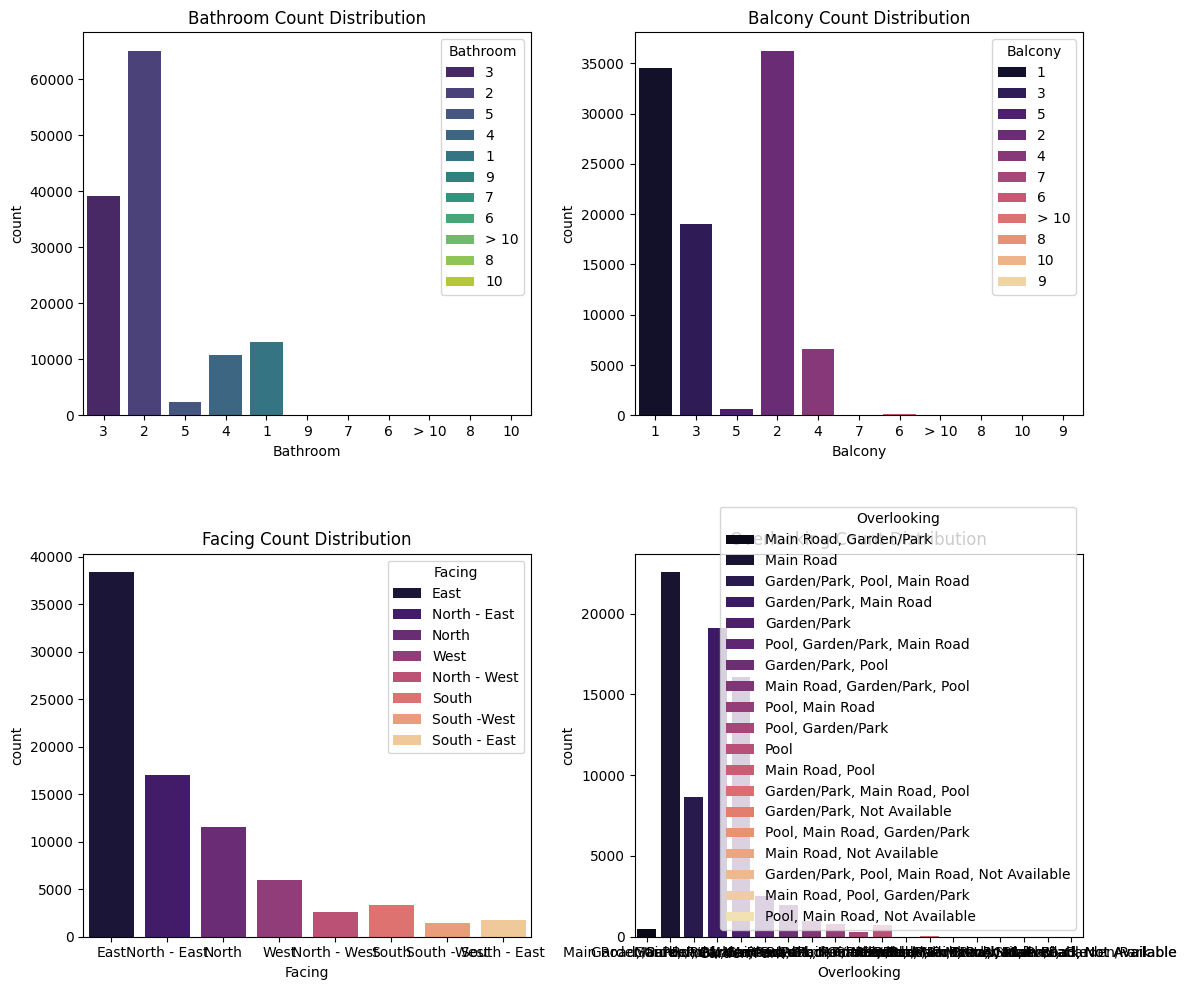

In [27]:
# Creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjusting the layout to have 2 rows and 2 columns

# Bathroom count plot
sns.countplot(data=df_train_cleaned, x="Bathroom", hue="Bathroom", palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title("Bathroom Count Distribution")

# Balcony count plot
sns.countplot(data=df_train_cleaned, x="Balcony", hue="Balcony", palette="magma", ax=axes[0, 1])
axes[0, 1].set_title("Balcony Count Distribution")

# Facing count plot
sns.countplot(data=df_train_cleaned, x="Facing", hue="Facing", palette="magma",ax=axes[1, 0])
axes[1, 0].set_title("Facing Count Distribution")

# Overlooking count plot
sns.countplot(data=df_train_cleaned, x="Overlooking", hue="Overlooking", palette="magma", ax=axes[1, 1])
axes[1, 1].set_title("Overlooking Count Distribution")

# Show the plots
plt.tight_layout()
plt.show()

In [28]:
# Replace '> 10' with 11 Bathroom and Balcony columns in the train dataset
df_train_cleaned['Bathroom'] = df_train_cleaned['Bathroom'].map(
    lambda x: 11 if isinstance(x, str) and x.strip() == '> 10' else x
)
df_train_cleaned['Balcony'] = df_train_cleaned['Balcony'].map(
    lambda x: 11 if isinstance(x, str) and x.strip() == '> 10' else x
)

# Fixing Bathroom and Balcony columns in the test dataset
df_test_cleaned['Bathroom'] = df_test_cleaned['Bathroom'].map(
    lambda x: 11 if isinstance(x, str) and x.strip() == '> 10' else x
)
df_test_cleaned['Balcony'] = df_test_cleaned['Balcony'].map(
    lambda x: 11 if isinstance(x, str) and x.strip() == '> 10' else x
)

#Replace explicit null values in 'Facing' & 'Overlooking' with 'Unknown'
cols_to_fill_unknown = ['Facing', 'Overlooking','Ownership']
df_train_cleaned[cols_to_fill_unknown] = df_train_cleaned[cols_to_fill_unknown].fillna('Unknown')
df_test_cleaned[cols_to_fill_unknown] = df_test_cleaned[cols_to_fill_unknown].fillna('Unknown')


In [29]:
#Very Less NaN Cases 0.02% to 1.56% : Remove rows with NaN values in 'Transaction', 'Bathroom', 'Furnishing' columns since %
df_train_cleaned = df_train_cleaned.dropna(subset=['Transaction', 'Bathroom', 'Furnishing'])
df_test_cleaned = df_test_cleaned.dropna(subset=['Transaction', 'Bathroom', 'Furnishing'])


In [30]:
analyze_missing_value(df_train_cleaned)


,Column Name,Data Type,Unique Values,Total Rows,Explicit Nulls,Implicit Nulls,Total Nulls,Null Percentage
0,Price,object,1481,129127,0,0,0,0.00
1,Location,object,81,129127,0,0,0,0.00
2,Carpet Area,object,2470,129127,54409,0,54409,42.14
3,Floor,object,885,129127,4409,0,4409,3.41
4,Transaction,object,4,129127,0,0,0,0.00
5,Furnishing,object,3,129127,0,0,0,0.00
6,Facing,object,9,129127,0,0,0,0.00
7,Overlooking,object,20,129127,0,0,0,0.00
8,Bathroom,object,11,129127,0,0,0,0.00
9,Balcony,object,11,129127,32603,0,32603,25.25


In [31]:
#Converting Balcony dataype to int
df_train_cleaned['Balcony'] = pd.to_numeric(df_train_cleaned['Balcony'], errors='coerce').fillna(0).astype(int)
df_test_cleaned['Balcony'] = pd.to_numeric(df_test_cleaned['Balcony'], errors='coerce').fillna(0).astype(int)

df_train_cleaned['Bathroom'] = pd.to_numeric(df_train_cleaned['Bathroom'], errors='coerce').fillna(0).astype(int)
df_test_cleaned['Bathroom'] = pd.to_numeric(df_test_cleaned['Bathroom'], errors='coerce').fillna(0).astype(int)

In [32]:
#Replace explicit null values in 'Balcony' with Mean
df_train_cleaned['Balcony'] = df_train_cleaned['Balcony'].fillna(df_train_cleaned['Balcony'].mean())
df_test_cleaned['Balcony'] = df_test_cleaned['Balcony'].fillna(df_test_cleaned['Balcony'].mean())

In [33]:
#This function splits a specified column into two parts based on the first space, creating two new columns, and then drops the original column from the DataFrame.
def split_col(df, col):
    if col in df.columns:
        if df[col].str.contains(' ').any():
            df[[f'{col} Part 1', f'{col} Part 2']] = df[col].str.split(' ', n=1, expand=True)
        else:
            df[[f'{col} Part 1', f'{col} Part 2']] = df[[col, None]]
        df.drop(columns=[col], inplace=True)

    return df


In [34]:
# Columns to split
to_split = ['Carpet Area','Price','Super Area','Floor']
to_convert = ['Carpet Area Part 1','Price Part 1','Super Area Part 1']

# Apply the function to both train and test datasets
for col in to_split:
    df_train_cleaned = split_col(df_train_cleaned, col)
    df_test_cleaned = split_col(df_test_cleaned, col)

#Convert Data Type to Numeric Value
def convert_to_numeric(df, col):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

for col in to_convert:
    df_train_cleaned = convert_to_numeric(df_train_cleaned, col)
    df_test_cleaned = convert_to_numeric(df_test_cleaned, col)


In [35]:
#Value Distribution
def value_distribution(df, column):
    value_counts = df[column].value_counts(normalize=True) * 100
    table = pd.DataFrame({'Value': value_counts.index, 'Percentage': value_counts.values})
    return table

In [36]:
result = value_distribution(df_train_cleaned, 'Carpet Area Part 2')
print('Before')
print(result)

Before
   Value  Percentage
0   sqft   93.902406
1  sqyrd    5.265130
2    sqm    0.823095
3  marla    0.002677
4  kanal    0.002677
5   acre    0.001338
6  bigha    0.001338
7   cent    0.001338


In [37]:
#Create a list of values to filter out in 'Carpet Area Part 2'
values_to_remove = ['sqm','acre','ground','cent','bigha','marla','kanal','biswa2','aankadam','hectare']

#Remove rows where 'Carpet Area Part 2' contains any of the specified values
df_train_cleaned = df_train_cleaned[~df_train_cleaned['Carpet Area Part 2'].isin(values_to_remove)]
df_test_cleaned = df_test_cleaned[~df_test_cleaned['Carpet Area Part 2'].isin(values_to_remove)]

print('After')
result = value_distribution(df_train_cleaned, 'Carpet Area Part 2')
print(result)

def convert_sqyrd_to_sqft(df, area_col, reference_col):
    mask = df[area_col].astype(str).str.contains('sqyrd', na=False)
    # Multiply 'Carpet Area Part 1' by 9 where 'Carpet Area Part 2' contains 'sqyrd'
    df.loc[mask, reference_col] = df.loc[mask, reference_col] * 9
    return df

# Apply to train and test datasets
df_train_cleaned = convert_sqyrd_to_sqft(df_train_cleaned, 'Carpet Area Part 2', 'Carpet Area Part 1')
df_test_cleaned = convert_sqyrd_to_sqft(df_test_cleaned, 'Carpet Area Part 2', 'Carpet Area Part 1')

#Removing Carpet Area 2 Column
df_train_cleaned = df_train_cleaned.drop('Carpet Area Part 2', axis=1)
df_test_cleaned = df_test_cleaned.drop('Carpet Area Part 2', axis=1)

# Rename 'Carpet Area Part 1' to 'Carpet Area'
df_train_cleaned = df_train_cleaned.rename(columns={'Carpet Area Part 1': 'Carpet Area'})
df_test_cleaned = df_test_cleaned.rename(columns={'Carpet Area Part 1': 'Carpet Area'})

After
   Value  Percentage
0   sqft   94.690672
1  sqyrd    5.309328


In [38]:
result = value_distribution(df_train_cleaned, 'Super Area Part 2')
print('Before')
print(result)

Before
     Value  Percentage
0     sqft   94.381464
1    sqyrd    4.488572
2      sqm    1.107880
3    marla    0.007361
4    kanal    0.003681
5   ground    0.003681
6     acre    0.001840
7  hectare    0.001840
8   biswa2    0.001840
9     cent    0.001840


In [39]:
#Create a list of values to filter out in 'Super Area Part 2'
values_to_remove = ['sqm','acre','ground','cent','bigha','marla','kanal','biswa2','aankadam','hectare',]

#Remove rows where 'Super Area Part 2' contains any of the specified values
df_train_cleaned = df_train_cleaned[~df_train_cleaned['Super Area Part 2'].isin(values_to_remove)]
df_test_cleaned = df_test_cleaned[~df_test_cleaned['Super Area Part 2'].isin(values_to_remove)]

print('After')
result = value_distribution(df_train_cleaned, 'Super Area Part 2')
print(result)

# Apply to train and test datasets
df_train_cleaned = convert_sqyrd_to_sqft(df_train_cleaned, 'Super Area Part 2', 'Super Area Part 1')
df_test_cleaned = convert_sqyrd_to_sqft(df_test_cleaned, 'Super Area Part 2', 'Super Area Part 1')

#Removing Carpet Area 2 Column
df_train_cleaned = df_train_cleaned.drop('Super Area Part 2', axis=1)
df_test_cleaned = df_test_cleaned.drop('Super Area Part 2', axis=1)

# Rename 'Carpet Area Part 1' to 'Super Area'
df_train_cleaned = df_train_cleaned.rename(columns={'Super Area Part 1': 'Super Area'})
df_test_cleaned = df_test_cleaned.rename(columns={'Super Area Part 1': 'Super Area'})

After
   Value  Percentage
0   sqft    95.46013
1  sqyrd     4.53987


In [40]:
# Replace null values in 'Carpet Area' with 70% of the corresponding 'Super Area' value
df_train_cleaned['Carpet Area'] = df_train_cleaned['Carpet Area'].fillna(df_train_cleaned['Super Area'] * 0.7)
df_test_cleaned['Carpet Area'] = df_test_cleaned['Carpet Area'].fillna(df_test_cleaned['Super Area'] * 0.7)

# Removing 'Super Area' Column
df_train_cleaned = df_train_cleaned.drop('Super Area', axis=1)
df_test_cleaned = df_test_cleaned.drop('Super Area', axis=1)

# Remove Remaining Nulls from 'Carpet Area'
df_train_cleaned = df_train_cleaned.dropna(subset=['Carpet Area'])
df_test_cleaned = df_test_cleaned.dropna(subset=['Carpet Area'])


In [41]:
result = value_distribution(df_train_cleaned, 'Price Part 2')
print('Before')
print(result)


Before
       Value  Percentage
0       Lac    59.902807
1        Cr    35.312669
2  for Price    4.784524


In [42]:
#Remove rows where 'Price Part 2' contains any of the 'for Price' as that was 'Call for Price'
df_train_cleaned = df_train_cleaned[~df_train_cleaned['Price Part 2'].isin(['for Price'])]
df_test_cleaned = df_test_cleaned[~df_test_cleaned['Price Part 2'].isin(['for Price'])]

print('After')
result = value_distribution(df_train_cleaned, 'Price Part 2')
print(result)

def convert_lac_cr(df, area_col, reference_col):
    # Check if 'Price Part 2' contains 'Lac', or 'Cr'
    mask_lac = df[area_col].astype(str).str.contains('Lac', na=False)
    mask_cr = df[area_col].astype(str).str.contains('Cr', na=False)

    # Multiply reference column based on 'sqyrd', 'Lac', or 'Cr'
    df.loc[mask_lac, reference_col] = df.loc[mask_lac, reference_col] * 100000
    df.loc[mask_cr, reference_col] = df.loc[mask_cr, reference_col] * 10000000

    return df

# Apply to train and test datasets
df_train_cleaned = convert_lac_cr(df_train_cleaned, 'Price Part 2', 'Price Part 1')
df_test_cleaned = convert_lac_cr(df_test_cleaned, 'Price Part 2', 'Price Part 1')

#Removing Price Column
df_train_cleaned = df_train_cleaned.drop('Price Part 2', axis=1)
df_test_cleaned = df_test_cleaned.drop('Price Part 2', axis=1)

# Rename 'Price Part 1' to 'Price'
df_train_cleaned = df_train_cleaned.rename(columns={'Price Part 1': 'Price'})
df_test_cleaned = df_test_cleaned.rename(columns={'Price Part 1': 'Price'})

#Changing Data Type
df_train_cleaned['Price'] = pd.to_numeric(df_train_cleaned['Price'], errors='coerce')
df_test_cleaned['Price'] = pd.to_numeric(df_test_cleaned['Price'], errors='coerce')

After
  Value  Percentage
0  Lac    62.912889
1   Cr    37.087111


In [43]:
result = value_distribution(df_train_cleaned, 'Floor Part 2')
print('Before')
print(result)

Before
                 Value  Percentage
0             out of 4   23.125570
1             out of 5   10.715168
2             out of 3   10.556640
3            out of 10    7.751707
4             out of 6    5.216954
..                 ...         ...
91          out of 200    0.000852
92  Basement out of 29    0.000852
93           out of 48    0.000852
94           out of 68    0.000852
95           out of 58    0.000852

[96 rows x 2 columns]


In [44]:
#Removing Floor Part 2 Column
df_train_cleaned = df_train_cleaned.drop('Floor Part 2', axis=1)
df_test_cleaned = df_test_cleaned.drop('Floor Part 2', axis=1)

# Rename 'Floor Part 1' to 'Floor'
df_train_cleaned = df_train_cleaned.rename(columns={'Floor Part 1': 'Floor'})
df_test_cleaned = df_test_cleaned.rename(columns={'Floor Part 1': 'Floor'})

print(df_train_cleaned['Floor'].unique())

['31' nan 'Ground' '6' '3' '5' '12' '8' '1' '4' '2' '18' '9' '10' '11' '7'
 '32' 'Upper' '20' '23' '14' '19' '15' '17' '13' '16' '21' '28' 'Lower'
 '26' '25' '27' '22' '30' '40' '24' '42' '44' '70' '29' '45' '34' '35'
 '36' '33' '60' '38' '59' '39' '46' '75' '51' '200']


In [45]:
df_train_cleaned['Floor'] = df_train_cleaned['Floor'].replace('Ground', '0')
df_test_cleaned['Floor'] = df_test_cleaned['Floor'].replace('Ground', '0')

df_train_cleaned['Floor'] = df_train_cleaned['Floor'].replace('Upper', '0')
df_test_cleaned['Floor'] = df_test_cleaned['Floor'].replace('Upper', '0')

df_train_cleaned['Floor'] = df_train_cleaned['Floor'].replace('Lower', '-1')
df_test_cleaned['Floor'] = df_test_cleaned['Floor'].replace('Lower', '-1')

In [46]:
df_train_cleaned['Floor'] = pd.to_numeric(df_train_cleaned['Floor'], errors='coerce')
df_test_cleaned['Floor'] = pd.to_numeric(df_test_cleaned['Floor'], errors='coerce')

In [47]:
#Setting it to Median to save it become outliers, also the unique count is less so it will act like Classification label than Numeric
df_train_cleaned['Floor'] = df_train_cleaned['Floor'].fillna(df_train_cleaned['Floor'].median())
df_test_cleaned['Floor'] = df_test_cleaned['Floor'].fillna(df_test_cleaned['Floor'].median())

In [48]:
analyze_missing_value(df_train_cleaned)


,Column Name,Data Type,Unique Values,Total Rows,Explicit Nulls,Implicit Nulls,Total Nulls,Null Percentage
0,Location,object,81,121673,0,0,0,0.00
1,Transaction,object,4,121673,0,0,0,0.00
2,Furnishing,object,3,121673,0,0,0,0.00
3,Facing,object,9,121673,0,0,0,0.00
4,Overlooking,object,19,121673,0,0,0,0.00
5,Bathroom,int64,11,121673,0,0,0,0.00
6,Balcony,int64,12,121673,0,61888,61888,50.86
7,Ownership,object,5,121673,0,0,0,0.00
8,Carpet Area,float64,4231,121673,0,0,0,0.00
9,Price,float64,1473,121673,0,0,0,0.00


In [49]:
analyze_anomalies(df_train_cleaned)


,Column Name,Data Type,Anomaly Count (IQR),Is Datatype Consistet
0,Location,object,0,0
1,Transaction,object,0,0
2,Furnishing,object,0,0
3,Facing,object,0,0
4,Overlooking,object,0,0
5,Bathroom,int64,2473,0
6,Balcony,int64,115,0
7,Ownership,object,0,0
8,Carpet Area,float64,6326,0
9,Price,float64,7103,0


In [50]:
def cap_outliers(df):
    """Caps outliers using the IQR method instead of removing them."""
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

    # Calculate Q1, Q3, and IQR for each numerical feature
    Q1 = df[numerical_features].quantile(0.25)
    Q3 = df[numerical_features].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values outside the range
    df[numerical_features] = df[numerical_features].clip(lower=lower_bound, upper=upper_bound, axis=1)

    return df


df_train_outlier_removed = cap_outliers(df_train_cleaned)
df_test_outlier_removed = cap_outliers(df_test_cleaned)

analyze_anomalies(df_train_outlier_removed)

,Column Name,Data Type,Anomaly Count (IQR),Is Datatype Consistet
0,Location,object,0,0
1,Transaction,object,0,0
2,Furnishing,object,0,0
3,Facing,object,0,0
4,Overlooking,object,0,0
5,Bathroom,float64,0,0
6,Balcony,int64,0,0
7,Ownership,object,0,0
8,Carpet Area,float64,0,0
9,Price,float64,0,0


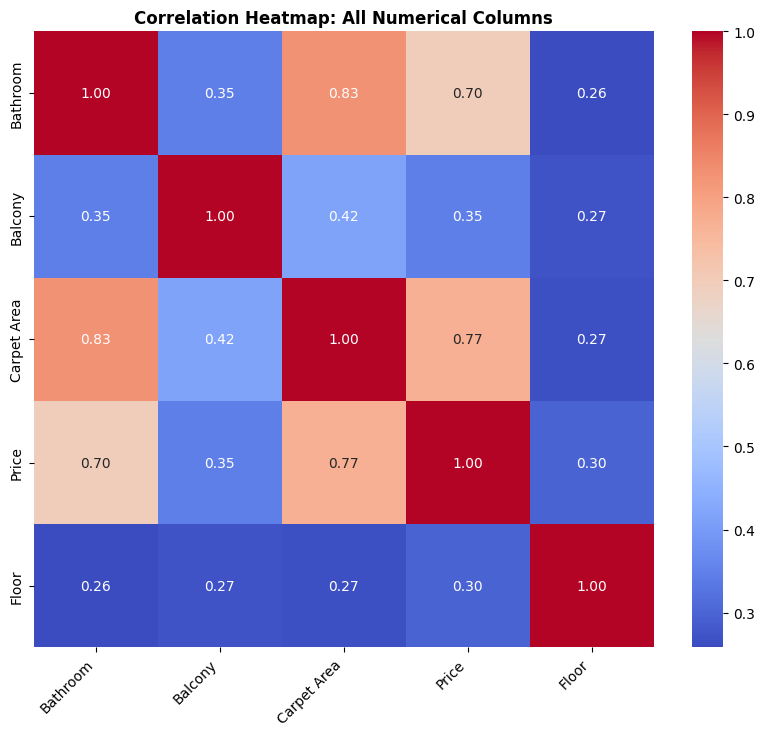

In [51]:
numeric_cols = df_train_outlier_removed.select_dtypes(include=['number'])

correlation_matrix = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: All Numerical Columns',fontweight='bold')
plt.xticks(rotation=45,ha='right')
plt.show()

In [52]:
#Spliting Feauter Vectors and Target Label
y_train = df_train_outlier_removed['Price']
x_train = df_train_outlier_removed.drop('Price', axis=1)

y_test = df_test_outlier_removed['Price']
x_test = df_test_outlier_removed.drop('Price', axis=1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((121673, 10), (121673,), (52157, 10), (52157,))

In [53]:
# Define the numerical and categorical columns
numerical_cols = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = x_train.select_dtypes(include=['object']).columns

print(f'Categorical Col : {list(categorical_cols)} \nNumerical Col : {list(numerical_cols)}')

# Create ColumnTransformer
ct =ColumnTransformer(
    transformers=[
        ('scaling', StandardScaler(), numerical_cols),
        ('onehot', OneHotEncoder(drop='first'), categorical_cols)  # drop='first' to avoid multicollinearity
    ]
)

# Apply ColumnTransformer to training data
x_train_transformed = ct.fit_transform(x_train)

# Apply the same transformation to test data
x_test_transformed = ct.transform(x_test)

# Check the shapes of the transformed datasets
print(f"Shape of x_train after transformation: {x_train_transformed.shape}")
print(f"Shape of y_train after transformation: {y_train.shape}")
print(f"Shape of x_test after transformation: {x_test_transformed.shape}")
print(f"Shape of y_test after transformation: {y_test.shape}")

Categorical Col : ['Location', 'Transaction', 'Furnishing', 'Facing', 'Overlooking', 'Ownership'] 
Numerical Col : ['Bathroom', 'Balcony', 'Carpet Area', 'Floor']
Shape of x_train after transformation: (121673, 119)
Shape of y_train after transformation: (121673,)
Shape of x_test after transformation: (52157, 119)
Shape of y_test after transformation: (52157,)


In [54]:
# Ensure that features and labels are split together in a way that the row count matches
x_test, x_valid, y_test, y_valid = train_test_split( x_test_transformed, y_test, test_size=0.5, random_state=42)

# Check the shapes after the split
print(x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(26079, 119) (26079,) (26078, 119) (26078,)


In [55]:
#Linear Regression (Baseline)
model_lr = LinearRegression()
model_lr.fit(x_train_transformed, y_train)
y_pred_lr = model_lr.predict(x_valid)
rmse_lr = np.sqrt(mean_squared_error(y_valid, y_pred_lr))
r2_lr = r2_score(y_valid, y_pred_lr)

#LightGBM Regression
model_lgb = lgb.LGBMRegressor(objective='regression', metric='l2')
model_lgb.fit(x_train_transformed, y_train)
y_pred_lgb = model_lgb.predict(x_valid)
rmse_lgb = np.sqrt(mean_squared_error(y_valid, y_pred_lgb))
r2_lgb = r2_score(y_valid, y_pred_lr)

#ElasticNet Regression
model_en = ElasticNet()
model_en.fit(x_train_transformed, y_train)
y_pred_en = model_en.predict(x_valid)
rmse_en = np.sqrt(mean_squared_error(y_valid, y_pred_en))
r2_en = r2_score(y_valid, y_pred_lr)

#XGBoost Regression
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
model_xgb.fit(x_train_transformed, y_train)
y_pred_xgb = model_xgb.predict(x_valid)
rmse_xgb = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))
r2_xgb = r2_score(y_valid, y_pred_lr)

#Compare Performance
results = pd.DataFrame({
    "Model": ["Linear Regression", "LightGBM", "ElasticNet", "XGBoost"],
    "RMSE": [rmse_lr, rmse_lgb, rmse_en, rmse_xgb],
    "R2": [r2_lr, r2_lgb, r2_en, r2_xgb]
}).sort_values(by="RMSE")

print("Baseline Model Performance (Lower RMSE is Better):")
print(results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 121673, number of used features: 109
[LightGBM] [Info] Start training from score 10698045.992126
Baseline Model Performance (Lower RMSE is Better):
               Model          RMSE        R2
3            XGBoost  2.062835e+06  0.749522
1           LightGBM  2.212171e+06  0.749522
0  Linear Regression  4.032537e+06  0.749522
2         ElasticNet  5.082459e+06  0.749522


In [ ]:
#XGBoost Hyperparameter Grid
xgb_params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 500, 1000, 2000],
    "max_depth": [3, 6, 10, 15],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

#Tune XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)
xgb_search.fit(x_train_transformed, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
best_xgb_params = xgb_search.best_params_
print("Best Hyperparameters for XGBoost:")
for param, value in best_xgb_params.items():
    print(f"\t{param}: {value}")


# Calculate RMSE (Root Mean Squared Error)
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

# Calculate Mean Absolute Error (MAE)
mae_xgb_tuned = mean_absolute_error(y_valid, y_pred_xgb)

# Calculate R-squared (R²) score
r2_xgb_tuned = r2_score(y_valid, y_pred_xgb)

# Print the tuned model's performance
print("\n",'- '*75,"\nPerformance After Hyperparameter Tuning:")
print(f"\tRMSE for Tuned XGBoost: {rmse_xgb_tuned}")
print(f"\tMAE for Tuned XGBoost: {mae_xgb_tuned}")
print(f"\tR² for Tuned XGBoost: {r2_xgb_tuned}")


In [ ]:
# Initialize the XGBoost model with the best parameters
model_xgb_best = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', **best_xgb_params)

# Train the model on the transformed training data
model_xgb_best.fit(x_train_transformed, y_train)

# Make predictions on the test set (or validation set, based on your choice)
y_pred_xgb_best = model_xgb_best.predict(x_test)

# Calculate RMSE (Root Mean Squared Error)
rmse_xgb_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))

# Calculate MAE (Mean Absolute Error)
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)

# Calculate R² (Coefficient of Determination)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

# Print the evaluation metrics
print(f"RMSE for XGBoost with Best Hyperparameters on Test Set: {rmse_xgb_best}")
print(f"\tRMSE for Tuned XGBoost: {rmse_xgb_best}")
print(f"\tMAE for Tuned XGBoost: {mae_xgb_best}")
print(f"\tR² for Tuned XGBoost: {r2_xgb_best}")
